# Decision Tree for N-dimensional data and labels
The code below implements a decision tree calculated on all the data, for one label depending on several independent variables.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import cm
from math import log, e
import random
import sys
import os
import matplotlib.image as mpimg
from IPython.core.display import Image, display
from tqdm import tqdm_notebook
from six.moves import reload_module

### Custom Libraries

In [2]:
from density_tree import *

# Generic Functions

The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


# Unsupervised entropy with unlabelled clusters
Below are some functions that compute an optimal split for unlabelled data, using the differential entropy of a d-variate Gaussian density. 

First, let's generate some unlabelled data:


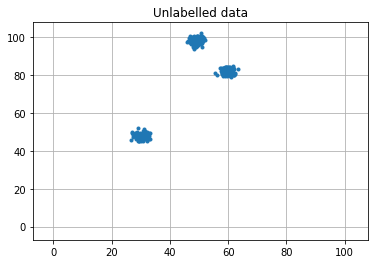

In [11]:
reload_module(density_tree)
dimensions = 2
nclusters = 3
covariance =  2
npoints = 100
minRange = 10
maxRange = 100

dataset, clusters = create_data.createData(nclusters, dimensions, covariance, npoints, 
                                              minRange=minRange, maxRange=maxRange)
#dataset=dataset[:,:-1]
figure, axes = plt.subplots(nrows = 1, ncols = 1)
plots.plotData(dataset, "Unlabelled data", axes, labels=False)
plt.show()

For tree descent, we have to decide how many clusters we want to produce (limit depth) or what should be the threshold of information gain for the algorithm to stop (information gain limit)

In [12]:
root = create_decision_tree_unlabelled(dataset, dimensions=2, clusters = nclusters)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/cyrilwendl/Documents/EPFL/Projet SIE/SIE-Project/Code/density_tree/density_tree.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  K = np.linalg.det(np.cov(S.T))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Library/Frameworks/Python.framework/Versi

In [13]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals)[np.not_equal(cut_vals,None)].astype(float)
cut_dims = np.asarray(cut_dims)[np.not_equal(cut_dims,None)].astype(int)

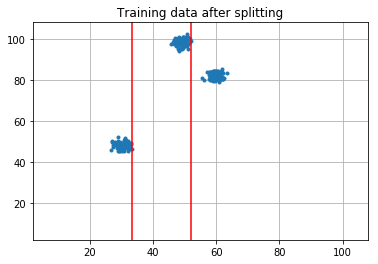

In [14]:
reload_module(plots)
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

fig, ax = plt.subplots(1,1)
plots.plotData(dataset, "Training data after splitting", ax, labels=False, linesX = x_split, linesY = y_split, 
                            minRange = minRange, maxRange = maxRange, covariance=covariance)

%clear
plt.show()

In [7]:
np.seterr(all='print')
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    dim_max, val_dim_max, ig_dims_vals, split_dims_vals  = get_best_split(dataset)

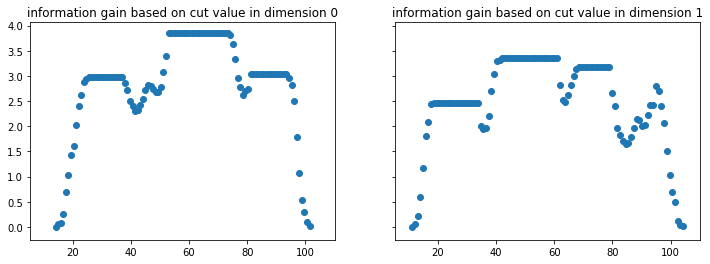

In [8]:
def show_ig(split_dims_vals, ig_dims_vals):
    f, axes = plt.subplots(1,2, sharex=True, sharey=True)
    f.set_size_inches((12,4))
    for dim in [0,1]:
        axes[dim].scatter(split_dims_vals[dim],ig_dims_vals[dim])
        axes[dim].set_title("information gain based on cut value in dimension "+str(dim))
    plt.show()

show_ig(split_dims_vals, ig_dims_vals)

# Labelled data

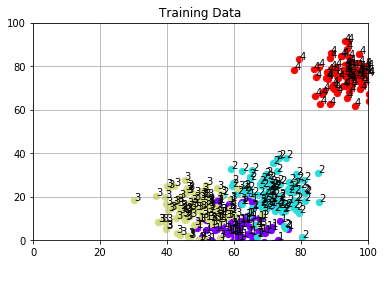

In [9]:
# cluster parameters
nclusters=4
dimensions=2
covariance=40
minRange=0
maxRange=100
npoints=100

    
dataset, clusters = create_data.createData(nclusters, dimensions, covariance, npoints, 
                                              minRange = minRange, maxRange = maxRange)

fig, ax = plt.subplots(1,1)
plots.plotData(clusters, "Training Data", ax, clusters=clusters,
                  minRange = minRange, maxRange = maxRange, covariance=0)
plt.show()

### Calculate the entropy over all possible split values in all dimensions (`calc_entropy attribute`)


Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [10]:
root = create_decision_tree(dataset)

In [11]:
root.depth()


9

In [12]:
reload_module(helpers)
dataset_grid_eval = get_grid_labels(dataset, root, minRange, maxRange)

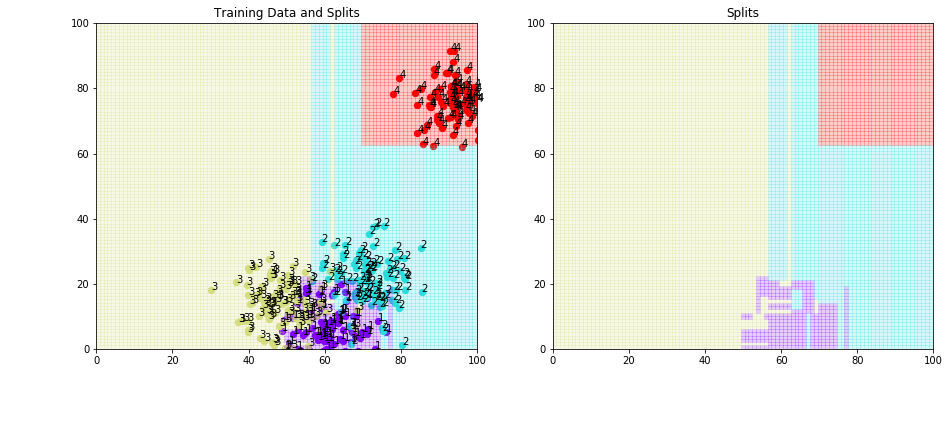

In [13]:
visualize_decision_boundaries(dataset, root, minRange, maxRange)

The overfitting of the tree clearly shows in the decision boundaries above.
# Output the decision forest to a $\LaTeX$ figure

In [14]:
tree_string = ""
tree_string = helpers.printstuff(root,tree_string)

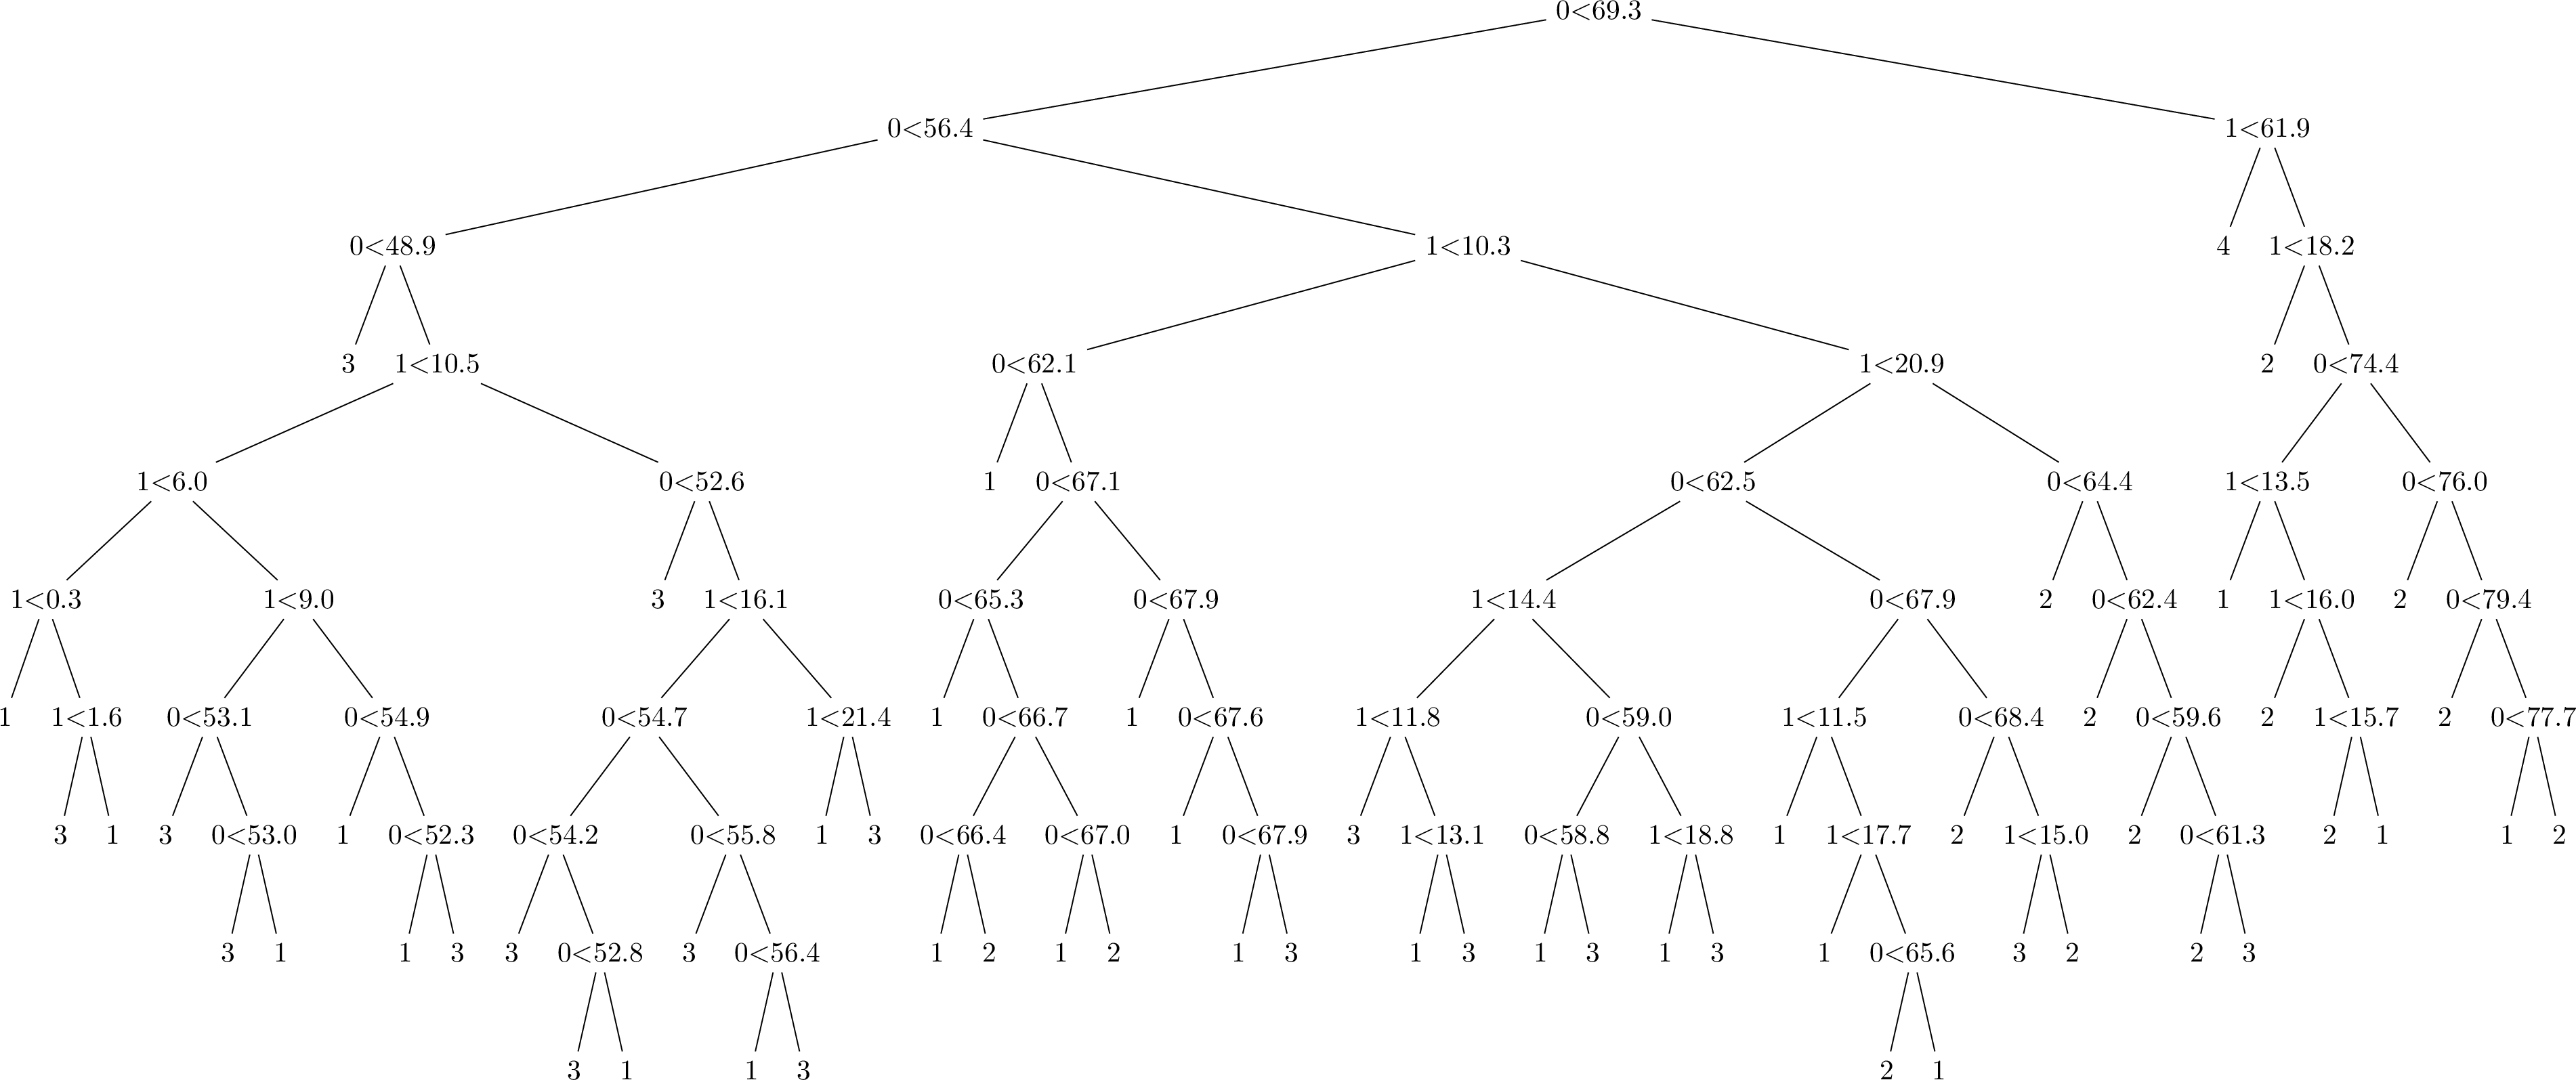

In [15]:
def tree_visualize(root):
    tree_string = ""
    tree_string = helpers.printstuff(root,tree_string)
    
    os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;  echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
    os.system("cd figures; pdflatex main.tex; convert -density 300 -trim main.pdf -quality 100 main.png")
    display(Image('./figures/main.png', retina=True))
    
tree_visualize(root)

We can see that the Decision Tree overfits and creates way too many splits. We will thus train many individual trees on a subset of the data.
# Random Forest
- Draw random subsamples of data with replacement
- Create individual decision trees on subsamples
- Visualize decision boundaries

In [21]:
root_nodes = random_forest.random_forest_build(dataset,1000,.3)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [22]:
# evaluate labels of original dataset using RF
dataset_test = dataset[:,:2]
dataset_eval = random_forest.random_forest_traverse(dataset_test,root_nodes)

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

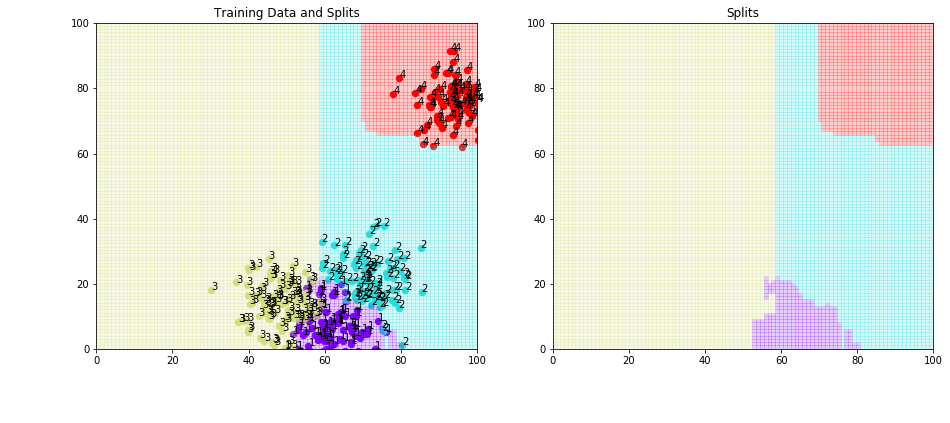

In [23]:
# show data using Random Forests
visualize_decision_boundaries(dataset_eval, root_nodes, minRange, maxRange, rf = True)

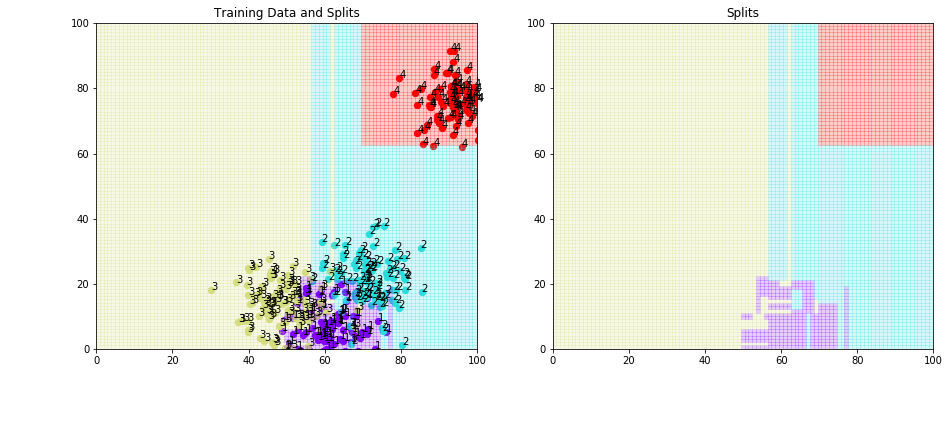

In [24]:
# compare to using only one decision tree:
visualize_decision_boundaries(dataset, root, minRange, maxRange)